In [1]:
## Reading the preprocessed dataset 
import pandas as pd
df = pd.read_csv(r'/Users/noortje/Documents/880502-M-18 | Master Thesis/Python/RQ1 dataset.csv')

## Reviewing the loaded dataset
df

,male,education,distance_store,health_status
0,685.0,0.032,0.266,0
1,616.0,0.034,0.297,0
2,713.0,0.142,0.267,0
3,604.0,0.321,0.075,0
4,1040.0,0.325,0.483,0
...,...,...,...,...
4831,784.0,0.406,0.354,0
4832,693.0,0.276,1.574,0
4833,880.0,0.431,0.652,0
4834,789.0,0.232,0.780,0


In [2]:
## RANDOM FOREST: IMPLEMENTATION FOR RQ1
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
import numpy as np

## Assign data to X and Y
X = df.drop('health_status', axis=1).values
Y = df['health_status'].values

## Splitting the data into a training and testing set
X_main, X_test, y_main, y_test = train_test_split(X, Y, 
test_size = 0.37, random_state = 101, stratify=Y)

## Splitting the main set into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, 
test_size = 0.23, random_state = 101, stratify=y_main)

## Feature scaling using RobustScaler to put all features to the same scale
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Implementing SMOTE on training data, to train the model on a balanced dataset
smote = SMOTE(random_state=101, sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

## Assigning sample weights
weights = np.zeros(len(y_res))
weights[y_res == 1] = 0.991
weights[y_res == 0] = 0.009

## Defining and fitting the model
model1 = RandomForestClassifier(random_state=101, n_estimators = 888,
min_samples_split = 5, min_samples_leaf = 22, max_samples = 800, max_features = 'sqrt',
max_depth = 7)

model1.fit(X_res, y_res, sample_weight = weights)

## Making predictions for every partition of the dataset 
pred_val = model1.predict(X_val_scaled)
pred_train = model1.predict(X_train_scaled)

## Evaluating the model performance
print('Balanced accuracy on validation data =', balanced_accuracy_score(y_val, pred_val))
print('Recall-score (positive class) on validation data =', recall_score(y_val, pred_val, pos_label = 1))
print('----------------------------------------------------------------------------------------------')
print('Checking for model overfitting by computing the evaluation metric on training data:')
print('-----------------')
print('Balanced accuracy on training data =', balanced_accuracy_score(y_train, pred_train))
print('Recall-score (positive class) on training data =', recall_score(y_train, pred_train, pos_label = 1))


Balanced accuracy on validation data = 0.6266187050359713
Recall-score (positive class) on validation data = 1.0
----------------------------------------------------------------------------------------------
Checking for model overfitting by computing the evaluation metric on training data:
-----------------
Balanced accuracy on training data = 0.6287128712871287
Recall-score (positive class) on training data = 1.0


In [4]:
## FINAL TRAINING ITERATION FOR RF - RQ1
## Feature scaling using RobustScaler to put all features to the same scale
scaler = RobustScaler()
X_main_scaled = scaler.fit_transform(X_main)
X_test_scaled = scaler.transform(X_test)

## Implementing SMOTE on training data, to train the model on a balanced dataset
smote = SMOTE(random_state=101, sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X_main_scaled, y_main)

## Assigning sample weights
weights = np.zeros(len(y_res))
weights[y_res == 1] = 0.991
weights[y_res == 0] = 0.009

## Defining and fitting the model
model1 = RandomForestClassifier(random_state=101, n_estimators = 888,
min_samples_split = 5, min_samples_leaf = 22, max_samples = 800, max_features = 'sqrt',
max_depth = 7)

model1.fit(X_res, y_res, sample_weight = weights)

## Making predictions for the testing partition of the dataset
pred_test_rf = model1.predict(X_test_scaled)
pred_train = model1.predict(X_main_scaled)

## Unbiased estimate on unseen data
print('Checking the final model performance by computing the evaluation metric on unseen testing data:')
print('-----------------')
print('Balanced accuracy on testing data =', balanced_accuracy_score(y_test, pred_test_rf))
print('Recall-score (positive class) on testing data =', recall_score(y_test, pred_test_rf, pos_label = 1))
print('-----------------')
print('Balanced accuracy on training data =', balanced_accuracy_score(y_main, pred_train))
print('Recall-score (positive class) on training data =', recall_score(y_main, pred_train, pos_label = 1))

Checking the final model performance by computing the evaluation metric on unseen testing data:
-----------------
Balanced accuracy on testing data = 0.574760428410372
Recall-score (positive class) on testing data = 0.875
-----------------
Balanced accuracy on training data = 0.6150123071097227
Recall-score (positive class) on training data = 0.9642857142857143


In [ ]:
## HYPERPARAMETER TUNING PROCESS FOR RQ1 - RANDOM FOREST
## Source of code: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
## Random search iteration 1: 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np

## Creating the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=50, stop = 500, num = 10)],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [int(x) for x in np.linspace(start=1, stop = 15, num = 5)],
            'min_samples_split': [int(x) for x in np.linspace(start=1, stop = 50, num = 5)],
            'min_samples_leaf': [int(x) for x in np.linspace(start=1, stop = 50, num = 10)],
            'max_samples': [int(x) for x in np.linspace(start=100, stop = 1000, num = 10)]}

## Creating the model to tune
rf = RandomForestClassifier(random_state=101)

## Random search procedure of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=101, n_jobs = -1)

## Fitting the random search model to the previously defined resampled dataset using SMOTE
rf_random.fit(X_res, y_res)

## Retrieving the best model parameters according to this iteration
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=15, max_features=log2, max_samples=200, min_samples_leaf=44, min_samples_split=13, n_estimators=500; total time=   2.1s
[CV] END max_depth=15, max_features=log2, max_samples=200, min_samples_leaf=44, min_samples_split=13, n_estimators=500; total time=   2.1s
[CV] END max_depth=15, max_features=log2, max_samples=200, min_samples_leaf=44, min_samples_split=13, n_estimators=500; total time=   2.1s
[CV] END max_depth=15, max_features=log2, max_samples=200, min_samples_leaf=44, min_samples_split=13, n_estimators=500; total time=   2.1s
[CV] END max_depth=4, max_features=log2, max_samples=600, min_samples_leaf=44, min_samples_split=37, n_estimators=100; total time=   0.5s
[CV] END max_depth=4, max_features=log2, max_samples=600, min_samples_leaf=44, min_samples_split=37, n_estimators=100; total time=   0.6s
[CV] END max_depth=4, max_features=log2, max_samples=600, min_samples_leaf=44, min_samples_split=37, n_esti

/Users/noortje/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/noortje/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/noortje/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/noortje/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator

{'n_estimators': 400,
 'min_samples_split': 37,
 'min_samples_leaf': 11,
 'max_samples': 500,
 'max_features': 'sqrt',
 'max_depth': 11}

In [ ]:
## HYPERPARAMETER TUNING PROCESS FOR RQ1 - RANDOM FOREST
## Source of code: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
## Random search iteration 2: 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np

## Creating the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop = 600, num = 10)],
            'max_features': ['sqrt'],
            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
            'min_samples_split': [int(x) for x in np.linspace(start=25, stop = 70, num = 5)],
            'min_samples_leaf': [int(x) for x in np.linspace(start=10, stop = 50, num = 5)],
            'max_samples': [int(x) for x in np.linspace(start=100, stop = 600, num = 10)]}

## Creating the model to tune
rf = RandomForestClassifier(random_state=101)

## Random search procedure of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=101, n_jobs = -1)

## Fitting the random search model to the previously defined resampled dataset using SMOTE
rf_random.fit(X_res, y_res)

## Retrieving the best model parameters according to this iteration
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=6, max_features=sqrt, max_samples=211, min_samples_leaf=40, min_samples_split=25, n_estimators=244; total time=   1.0s
[CV] END max_depth=6, max_features=sqrt, max_samples=211, min_samples_leaf=40, min_samples_split=25, n_estimators=244; total time=   1.0s
[CV] END max_depth=6, max_features=sqrt, max_samples=211, min_samples_leaf=40, min_samples_split=25, n_estimators=244; total time=   1.0s
[CV] END max_depth=6, max_features=sqrt, max_samples=211, min_samples_leaf=40, min_samples_split=25, n_estimators=244; total time=   1.0s
[CV] END max_depth=8, max_features=sqrt, max_samples=155, min_samples_leaf=40, min_samples_split=58, n_estimators=244; total time=   1.0s
[CV] END max_depth=6, max_features=sqrt, max_samples=211, min_samples_leaf=40, min_samples_split=25, n_estimators=244; total time=   1.0s
[CV] END max_depth=8, max_features=sqrt, max_samples=155, min_samples_leaf=40, min_samples_split=58, n_estimato

{'n_estimators': 511,
 'min_samples_split': 25,
 'min_samples_leaf': 30,
 'max_samples': 600,
 'max_features': 'sqrt',
 'max_depth': 7}

In [ ]:
## HYPERPARAMETER TUNING PROCESS FOR RQ1 - RANDOM FOREST
## Source of code: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
## Random search iteration 3: 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np

## Creating the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=500, stop = 1000, num = 10)],
            'max_features': ['sqrt'],
            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
            'min_samples_split': [int(x) for x in np.linspace(start=5, stop = 40, num = 5)],
            'min_samples_leaf': [int(x) for x in np.linspace(start=5, stop = 40, num = 5)],
            'max_samples': [int(x) for x in np.linspace(start=300, stop = 1000, num = 10)]}

## Creating the model to tune
rf = RandomForestClassifier(random_state=101)

## Random search procedure of parameters, using 3 fold cross validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=101, n_jobs = -1)

## Fitting the random search model to the previously defined resampled dataset using SMOTE
rf_random.fit(X_res, y_res)

## Retrieving the best model parameters according to this iteration
rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=6, max_features=sqrt, max_samples=455, min_samples_leaf=31, min_samples_split=5, n_estimators=555; total time=   2.3s
[CV] END max_depth=6, max_features=sqrt, max_samples=455, min_samples_leaf=31, min_samples_split=5, n_estimators=555; total time=   2.3s
[CV] END max_depth=6, max_features=sqrt, max_samples=455, min_samples_leaf=31, min_samples_split=5, n_estimators=555; total time=   2.4s
[CV] END max_depth=6, max_features=sqrt, max_samples=455, min_samples_leaf=31, min_samples_split=5, n_estimators=555; total time=   2.4s
[CV] END max_depth=8, max_features=sqrt, max_samples=377, min_samples_leaf=31, min_samples_split=31, n_estimators=555; total time=   2.5s
[CV] END max_depth=8, max_features=sqrt, max_samples=377, min_samples_leaf=31, min_samples_split=31, n_estimators=555; total time=   2.5s
[CV] END max_depth=6, max_features=sqrt, max_samples=455, min_samples_leaf=31, min_samples_split=5, n_estimators=55

{'n_estimators': 888,
 'min_samples_split': 5,
 'min_samples_leaf': 22,
 'max_samples': 1000,
 'max_features': 'sqrt',
 'max_depth': 7}

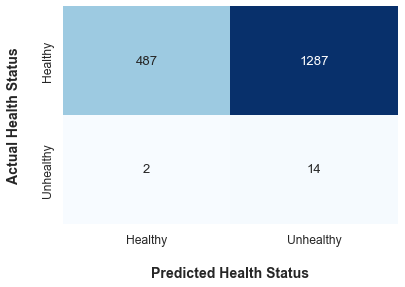

In [5]:
## Creating the confusion matrix for RF - RQ1
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Obtaining the confusion matrix
conf = confusion_matrix(y_test, pred_test_rf)

## Change figure size and font size
plt.figure(figsize=(6,4))
sns.set(font_scale = 1.1)

## Plotting confusion matrix
ax = sns.heatmap(conf, annot=True, fmt='d', cmap = 'Blues', cbar=False)
ax.set_xlabel("Predicted Health Status", fontsize=14, labelpad=20, fontweight = 'bold')
ax.xaxis.set_ticklabels(['Healthy', 'Unhealthy'])
ax.set_ylabel("Actual Health Status", fontsize=14, labelpad=20, fontweight = 'bold')
ax.yaxis.set_ticklabels(['Healthy', 'Unhealthy'])
plt.show()


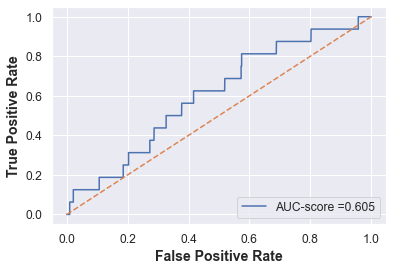

In [6]:
## Creating a ROC curve for RF RQ1
## Source of code: https://www.statology.org/plot-roc-curve-python/
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

## Defining the metrics
y_pred_proba_rf = model1.predict_proba(X_test_scaled)[::,1]
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba_rf, pos_label = 1)
auc = roc_auc_score(y_test, y_pred_proba_rf)

# Plotting the curve
plt.plot(fpr,tpr, label='AUC-score ='+str(f'{auc:.3f}'))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', fontsize = 14, fontweight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 14, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

In [8]:
## Error Analysis for RF - RQ1 - Obtaining a column indicating the misclassified instances
## Retrieving the feature names from the dataframe
feature_names = list(df.columns[:-1])

## Create a new dataframe for testing instances with feature names as column names
test_df = pd.DataFrame(X_test, columns=feature_names)

## Add the target feature 'health_status' to the dataframe
test_df2 = test_df.assign(health_status = y_test)

## Identifying the misclassified instances
misclassified = pred_test_rf != y_test

## Adding the column to the new dataset
test_df3 = test_df2.assign(misclassified_inst = misclassified)

## Reviewing the operation
test_df3

,male,education,distance_store,health_status,misclassified_inst
0,1079.0,0.199,0.158,0,False
1,858.0,0.093,0.339,0,True
2,982.0,0.416,0.286,0,True
3,802.0,0.329,0.431,0,True
4,832.0,0.262,0.305,0,True
...,...,...,...,...,...
1785,811.0,0.237,0.214,0,True
1786,892.0,0.373,0.247,0,True
1787,714.0,0.275,0.306,0,True
1788,1045.0,0.130,0.207,0,True


In [6]:
## Checking the median values for every feature
# NOTE: This code block was re-used for every feature, i.e., feature name replaced for every feature

## Obtaining the misclassified "healthy" cases
rows_unhealthy_TP = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == False)]
rows_unhealthy_FP = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == True)]

## Obtaining the median of all features for the correctly and incorrectly classified instances
median_male_TP = rows_unhealthy_TP['male'].median()
median_male_FP = rows_unhealthy_FP['male'].median()
median_edu_TP = rows_unhealthy_TP['education'].median()
median_edu_FP = rows_unhealthy_FP['education'].median()
median_distance_TP = rows_unhealthy_TP['distance_store'].median()
median_distance_FP = rows_unhealthy_FP['distance_store'].median()

## Reviewing the results
print('Median value for correctly classified "male" feature =', median_male_TP)
print('Median value for miscorrectly classified "male" feature =', median_male_FP)
print('Median value for correctly classified "education" feature =', median_edu_TP)
print('Median value for miscorrectly classified "education" feature =', median_edu_FP)
print('Median value for correctly classified "distance" feature =', median_distance_TP)
print('Median value for miscorrectly classified "distance" feature =', median_distance_FP)

Median value for correctly classified "male" feature = 805.0
Median value for miscorrectly classified "male" feature = 929.5
Median value for correctly classified "education" feature = 0.2835
Median value for miscorrectly classified "education" feature = 0.27449999999999997
Median value for correctly classified "distance" feature = 0.4175
Median value for miscorrectly classified "distance" feature = 0.1495


In [16]:
## Mann Whitney U test for comparing median values obtained in the previous step
# NOTE: This code block was re-used for every class, i.e., target label was replaces
import scipy.stats as stats
import numpy as np

## Obtaining two groups with the particular median value
rows_healthy_TN = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == False)]
rows_healthy_FN = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == True)]
group1 = rows_healthy_TN['distance_store'].values
group2 = rows_healthy_FN['distance_store'].values

#perform the Mann-Whitney U test
s, p = stats.mannwhitneyu(group1, group2)
print('Statistic =', s, 'p-value =', p)

Statistic = 26.0 p-value = 0.06666666666666667


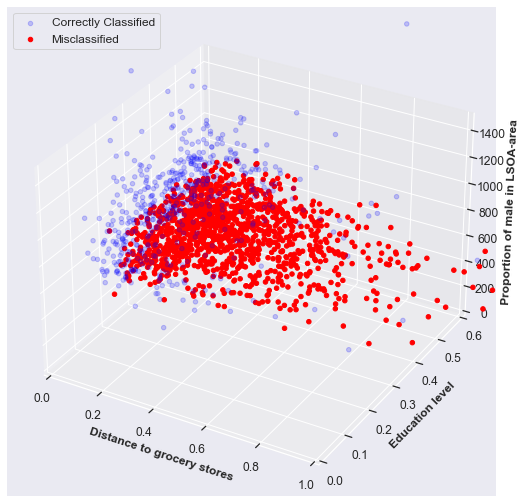

In [9]:
## Obtaining a 3D scatterplot for the overall misclassification pattern
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Assigning the features
z = test_df3['male']
y = test_df3['education']
x = test_df3['distance_store']
misclassified = test_df3['misclassified_inst']

## Obtaining the correctly and misclassified datapoints
correct_indices = np.where(misclassified == False)[0]
misclassified_indices = np.where(misclassified == True)[0]

## Plotting the figure
fig = plt.figure(figsize = (9, 9))
ax = plt.axes(projection='3d')
ax.set_xlim([0.00, 1.00])
ax.set_ylim([0.00, 0.6])
ax.set_zlim([0, 1500])
ax.scatter3D(x[correct_indices], y[correct_indices], z[correct_indices], c='blue', label='Correctly Classified', alpha = 0.2)
ax.scatter3D(x[misclassified_indices], y[misclassified_indices], z[misclassified_indices], c='red', label='Misclassified', alpha = 1.0)
ax.set_zlabel('Proportion of male in LSOA-area', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Education level', fontsize = 12, fontweight = 'bold')
ax.set_xlabel('Distance to grocery stores', fontsize = 12, fontweight = 'bold')
ax.legend(prop={'size': 12})
plt.show()

In [10]:
## GRADIENT BOOSTED DECISION TREE: IMPLEMENTATION FOR RQ1
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler
import numpy as np

## Assign data to X and Y
X = df.drop('health_status', axis=1).values
Y = df['health_status'].values

## Splitting the data into a training and testing set
X_main, X_test, y_main, y_test = train_test_split(X, Y, 
test_size = 0.37, random_state = 101, stratify=Y)

## Splitting the main set into a training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, 
test_size = 0.23, random_state = 101, stratify=y_main)

## Feature scaling using RobustScaler to put all features to the same scale
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Implementing SMOTE on training data, to train the model on a balanced dataset
smote = SMOTE(random_state=101, sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X_train_scaled, y_train)

## Assigning sample weights
weights = np.zeros(len(y_res))
weights[y_res == 1] = 0.991
weights[y_res == 0] = 0.009

## Defining and fitting the model
model2 = GradientBoostingClassifier(random_state=101, subsample = 0.5,
n_estimators = 100, min_samples_split = 70, min_samples_leaf = 31, max_depth = 4,
learning_rate = 0.6)

model2.fit(X_res, y_res, sample_weight = weights)

## Making predictions for every partition of the dataset 
pred_val = model2.predict(X_val_scaled)
pred_train = model2.predict(X_train_scaled)

## Evaluating the model performance
print('Balanced accuracy on validation data =', balanced_accuracy_score(y_val, pred_val))
print('Recall-score (positive class) on validation data =', recall_score(y_val, pred_val, pos_label = 1))
print('----------------------------------------------------------------------------------------------')
print('Checking for model overfitting by computing the evaluation metric on training data:')
print('-----------------')
print('Balanced accuracy on training data =', balanced_accuracy_score(y_train, pred_train))
print('Recall-score (positive class) on training data =', recall_score(y_train, pred_train, pos_label = 1))

Balanced accuracy on validation data = 0.6454436450839329
Recall-score (positive class) on validation data = 0.8333333333333334
----------------------------------------------------------------------------------------------
Checking for model overfitting by computing the evaluation metric on training data:
-----------------
Balanced accuracy on training data = 0.6466266191836575
Recall-score (positive class) on training data = 0.8636363636363636


In [11]:
## FINAL TRAINING ITERATION FOR GBDT - RQ1
## Feature scaling using RobustScaler to put all features to the same scale
scaler = RobustScaler()
X_main_scaled = scaler.fit_transform(X_main)
X_test_scaled = scaler.transform(X_test)

## Implementing SMOTE on training data, to train the model on a balanced dataset
smote = SMOTE(random_state=101, sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X_main_scaled, y_main)

## Assigning sample weights
weights = np.zeros(len(y_res))
weights[y_res == 1] = 0.991
weights[y_res == 0] = 0.009

## Defining and fitting the model
model2 = GradientBoostingClassifier(random_state=101, subsample = 0.5,
n_estimators = 100, min_samples_split = 70, min_samples_leaf = 31, max_depth = 4,
learning_rate = 0.6)

model2.fit(X_res, y_res, sample_weight = weights)

## Making predictions for the testing partition of the dataset
pred_test_gbdt = model2.predict(X_test_scaled)
pred_train = model2.predict(X_main_scaled)

## Unbiased estimate on unseen data
print('Checking the final model performance by computing the evaluation metric on unseen testing data:')
print('-----------------')
print('Balanced accuracy on testing data =', balanced_accuracy_score(y_test, pred_test_gbdt))
print('Recall-score (positive class) on testing data =', recall_score(y_test, pred_test_gbdt, pos_label = 1))
print('-----------------')
print('Balanced accuracy on training data =', balanced_accuracy_score(y_main, pred_train))
print('Recall-score (positive class) on training data =', recall_score(y_main, pred_train, pos_label = 1))

Checking the final model performance by computing the evaluation metric on unseen testing data:
-----------------
Balanced accuracy on testing data = 0.6281355693348365
Recall-score (positive class) on testing data = 0.6875
-----------------
Balanced accuracy on training data = 0.6832812647921992
Recall-score (positive class) on training data = 0.7857142857142857


In [ ]:
## HYPERPARAMETER TUNING PROCESS FOR RQ1 - GRADIENT BOOSTED DECISION TREE
## Source of code: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
## Random search iteration 1: 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np

## Creating the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=50, stop = 700, num = 10)],
            'learning_rate': [0.2, 0.5, 0.7, 0.9],
            'max_depth': [int(x) for x in np.linspace(start=1, stop = 15, num = 5)],
            'min_samples_split': [int(x) for x in np.linspace(start=5, stop = 100, num = 5)],
            'min_samples_leaf': [int(x) for x in np.linspace(start=5, stop = 100, num = 10)],
            'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.3, 1.5]}

## Creating the model to tune
gbdt = GradientBoostingClassifier(random_state=101)

## Random search procedure of parameters, using 3 fold cross validation
gbdt_random = RandomizedSearchCV(estimator = gbdt, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=101, n_jobs = -1)

## Fitting the random search model to the previously defined resampled dataset using SMOTE
gbdt_random.fit(X_res, y_res, sample_weight = weights)

## Retrieving the best model parameters according to this iteration
gbdt_random.best_params_

In [ ]:
## HYPERPARAMETER TUNING PROCESS FOR RQ1 - GRADIENT BOOSTED DECISION TREE
## Source of code: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
## Random search iteration 2: 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np

## Creating the random grid
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=50, stop = 700, num = 10)],
            'learning_rate': [0.2, 0.5, 0.7, 0.9],
            'max_depth': [int(x) for x in np.linspace(start=1, stop = 9, num = 5)],
            'min_samples_split': [int(x) for x in np.linspace(start=30, stop = 60, num = 5)],
            'min_samples_leaf': [int(x) for x in np.linspace(start=30, stop = 60, num = 10)],
            'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}


## Creating the model to tune
gbdt = GradientBoostingClassifier(random_state=101)

## Random search procedure of parameters, using 3 fold cross validation
gbdt_random = RandomizedSearchCV(estimator = gbdt, param_distributions = random_grid, n_iter = 10, cv = 5, verbose=2, random_state=101, n_jobs = -1)

## Fitting the random search model to the previously defined resampled dataset using SMOTE
gbdt_random.fit(X_res, y_res, sample_weight = weights)

## Retrieving the best model parameters according to this iteration
gbdt_random.best_params_

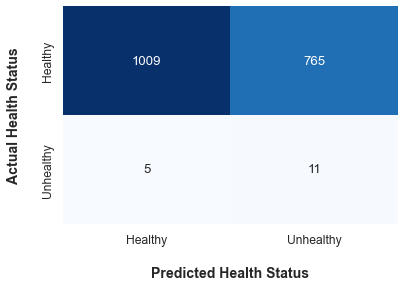

In [12]:
## Creating the confusion matrix for GBDT - RQ1
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Obtaining the confusion matrix
conf = confusion_matrix(y_test, pred_test_gbdt)

## Change figure size and font size
plt.figure(figsize=(6,4))
sns.set(font_scale = 1.1)

## Plotting confusion matrix
ax = sns.heatmap(conf, annot=True, fmt='d', cmap = 'Blues', cbar=False)
ax.set_xlabel("Predicted Health Status", fontsize=14, labelpad=20, fontweight = 'bold')
ax.xaxis.set_ticklabels(['Healthy', 'Unhealthy'])
ax.set_ylabel("Actual Health Status", fontsize=14, labelpad=20, fontweight = 'bold')
ax.yaxis.set_ticklabels(['Healthy', 'Unhealthy'])
plt.show()

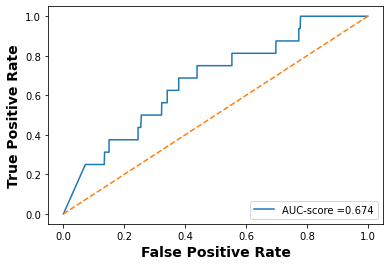

In [10]:
## Creating a ROC curve for GBDT RQ1
## Source of code: https://www.statology.org/plot-roc-curve-python/
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

## Define the metrics
y_pred_proba_gbdt = model2.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba_gbdt, pos_label = 1)
auc = roc_auc_score(y_test, y_pred_proba_gbdt)

# Plotting the curve
plt.plot(fpr,tpr, label='AUC-score ='+str(f'{auc:.3f}'))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate', fontsize = 14, fontweight = 'bold')
plt.xlabel('False Positive Rate', fontsize = 14, fontweight = 'bold')
plt.legend(loc=4)
plt.show()

In [24]:
## Error Analysis for GBDT - RQ1 - Obtaining a column indicating the misclassified instances
## Retrieving the feature names from the dataframe
feature_names = list(df.columns[:-1])

## Create a new dataframe for testing instances with feature names as column names
test_df = pd.DataFrame(X_test, columns=feature_names)

## Add the target feature 'health_status' to the dataframe
test_df2 = test_df.assign(health_status = y_test)

## Identifying the misclassified instances
misclassified = pred_test_gbdt != y_test

## Adding the column to the new dataset
test_df3 = test_df2.assign(misclassified_inst = misclassified)

## Reviewing the operation
test_df3

,male,education,distance_store,health_status,misclassified_inst
0,1079.0,0.199,0.158,0,False
1,858.0,0.093,0.339,0,False
2,982.0,0.416,0.286,0,False
3,802.0,0.329,0.431,0,True
4,832.0,0.262,0.305,0,True
...,...,...,...,...,...
1785,811.0,0.237,0.214,0,False
1786,892.0,0.373,0.247,0,False
1787,714.0,0.275,0.306,0,True
1788,1045.0,0.130,0.207,0,False


In [26]:
## Checking the median values for every feature
# NOTE: This code block was re-used for every feature, i.e., feature name replaced for every feature

## Obtaining the misclassified "healthy" cases
rows_unhealthy_TP = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == False)]
rows_unhealthy_FP = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == True)]

## Obtaining the median of all features for the correctly and incorrectly classified instances
median_male_TP = rows_unhealthy_TP['male'].median()
median_male_FP = rows_unhealthy_FP['male'].median()
median_edu_TP = rows_unhealthy_TP['education'].median()
median_edu_FP = rows_unhealthy_FP['education'].median()
median_distance_TP = rows_unhealthy_TP['distance_store'].median()
median_distance_FP = rows_unhealthy_FP['distance_store'].median()

## Reviewing the results
print('Median value for correctly classified "male" feature =', median_male_TP)
print('Median value for miscorrectly classified "male" feature =', median_male_FP)
print('Median value for correctly classified "education" feature =', median_edu_TP)
print('Median value for miscorrectly classified "education" feature =', median_edu_FP)
print('Median value for correctly classified "distance" feature =', median_distance_TP)
print('Median value for miscorrectly classified "distance" feature =', median_distance_FP)

Median value for correctly classified "male" feature = 788.0
Median value for miscorrectly classified "male" feature = 892.0
Median value for correctly classified "education" feature = 0.302
Median value for miscorrectly classified "education" feature = 0.18
Median value for correctly classified "distance" feature = 0.451
Median value for miscorrectly classified "distance" feature = 0.25


In [27]:
## Mann Whitney U test for comparing median values obtained in the previous step
# NOTE: This code block was re-used for every class, i.e., target label was replaces
import scipy.stats as stats
import numpy as np

## Obtaining two groups with the particular median value
rows_healthy_TN = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == False)]
rows_healthy_FN = test_df3[(test_df3['health_status'] == 1) & (test_df3['misclassified_inst'] == True)]
group1 = rows_healthy_TN['distance_store'].values
group2 = rows_healthy_FN['distance_store'].values

#perform the Mann-Whitney U test
s, p = stats.mannwhitneyu(group1, group2)
print('Statistic =', s, 'p-value =', p)

Statistic = 44.0 p-value = 0.06868131868131869


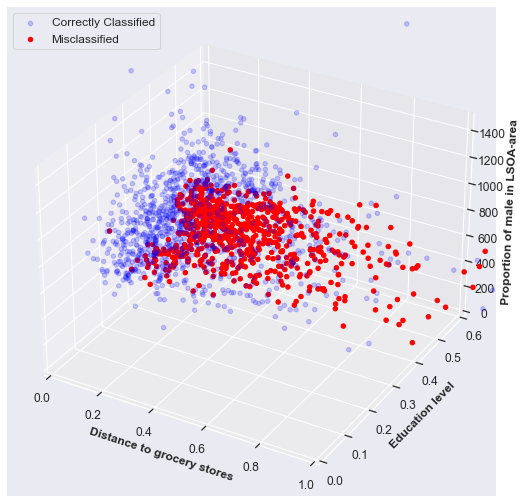

In [28]:
## Obtaining a 3D scatterplot for the overall misclassification pattern
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Assigning the features
z = test_df3['male']
y = test_df3['education']
x = test_df3['distance_store']
misclassified = test_df3['misclassified_inst']

## Obtaining the correctly and misclassified datapoints
correct_indices = np.where(misclassified == False)[0]
misclassified_indices = np.where(misclassified == True)[0]

## Plotting the figure
fig = plt.figure(figsize = (9, 9))
ax = plt.axes(projection='3d')
ax.set_xlim([0.00, 1.00])
ax.set_ylim([0.00, 0.6])
ax.set_zlim([0, 1500])
ax.scatter3D(x[correct_indices], y[correct_indices], z[correct_indices], c='blue', label='Correctly Classified', alpha = 0.2)
ax.scatter3D(x[misclassified_indices], y[misclassified_indices], z[misclassified_indices], c='red', label='Misclassified', alpha = 1.0)
ax.set_zlabel('Proportion of male in LSOA-area', fontsize = 12, fontweight = 'bold')
ax.set_ylabel('Education level', fontsize = 12, fontweight = 'bold')
ax.set_xlabel('Distance to grocery stores', fontsize = 12, fontweight = 'bold')
ax.legend(prop={'size': 12})
plt.show()

In [13]:
## McNemar test to compare model performance across RF and GBDT
## Source of code: https://rasbt.github.io/mlxtend/user_guide/evaluate/mcnemar/#:~:text=McNemar%27s%20Test%20Statistic&text=The%20McNemar%20test%20statistic%20(%22chi,a%20significance%20threshold%2C%20e.g%2C.
import numpy as np
from mlxtend.evaluate import mcnemar_table

tb = mcnemar_table(y_target=y_test, 
                   y_model1=pred_test_rf, 
                   y_model2=pred_test_gbdt)

## Performing the actual McNemar Test
from mlxtend.evaluate import mcnemar

chi2, p = mcnemar(ary=tb)
print('chi-squared:', chi2)
print('p-value:', p)

chi-squared: 488.75045537340617
p-value: 2.6650139979607327e-108
